In [9]:
!mkdir .kaggle
import json
token = {"username":"vkt706","key":"64f03ea3fe35f579d4ff0134ca2ed52d"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v/content
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘.kaggle’: File exists
- path is now set to: /content


In [10]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia --force

 99% 2.28G/2.29G [00:30<00:00, 29.4MB/s]
100% 2.29G/2.29G [00:30<00:00, 80.5MB/s]


In [ ]:
!unzip "/content/datasets/paultimothymooney/chest-xray-pneumonia/chest-xray-pneumonia.zip"

In [12]:
!mkdir /content/output
!mkdir /content/output/figures
!mkdir /content/output/models
!mkdir /content/output/logs
!mkdir /content/output/figures/result
!mkdir /content/output/figures/sample

mkdir: cannot create directory ‘/content/output’: File exists
mkdir: cannot create directory ‘/content/output/figures’: File exists
mkdir: cannot create directory ‘/content/output/models’: File exists
mkdir: cannot create directory ‘/content/output/logs’: File exists
mkdir: cannot create directory ‘/content/output/figures/result’: File exists
mkdir: cannot create directory ‘/content/output/figures/sample’: File exists


In [1]:
import sys
import os
import argparse
import random
import time
import datetime
from collections import Counter
import numpy as np
import pandas as pd
import shutil
from tqdm import tqdm
import inspect
import gc
import re
from PIL import Image
import cv2
import keras
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, GlobalAveragePooling1D, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense
from keras.applications.inception_v3 import InceptionV3
from keras.constraints import maxnorm
from keras import optimizers
from keras.optimizers import Adam, SGD , RMSprop
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
import tensorflow as tf
from IPython.display import display
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
input_directory = r"/content/chest_xray/"
output_directory = r"/content/output/"

training_dir = input_directory + r"train"
validation_dir = input_directory + r"val"
testing_dir = input_directory + r"test"


# figure_directory = r"data/output/figures"

# figure_directory = "data/output/figures"
# if not os.path.exists(figure_directory):
#     os.mkdir(figure_directory)
    
    
# file_name_pred_batch = figure_directory+r"/result"
# file_name_pred_sample = figure_directory+r"/sample"

In [3]:
def create_directory(directory_path, remove=False):
    if remove and os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
            os.mkdir(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
    else:
        try:
            os.mkdir(directory_path)
        except:
            print("Could not create directory: ", directory_path)
            return False
        
    return True

# Removes directory, if directory exists 
def remove_directory(directory_path):
    if os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
        
    return True

def clear_directory(directory_path):
    dirs_files = os.listdir(directory_path)
    
    for item in dirs_files:
#         item_path = os.path.join(directory_path, item)
        item_path = directory_path+ item
        
        try:
            if os.path.isfile(item_path):
                os.unlink(item_path)
            elif os.path.isdir(item_path): 
                shutil.rmtree(item_path)
        except Exception as e:
            print(e)
            
    return True


def remove_empty_folders(path, removeRoot=True):
    if not os.path.isdir(path):
        return
    
    # remove empty subfolders
    files = os.listdir(path)
    
    if len(files):
        for f in files:
            fullpath = os.path.join(path, f)
            
            if os.path.isdir(fullpath):
                remove_empty_folders(fullpath)

    # if folder empty, delete it
    files = os.listdir(path)
    
    if len(files) == 0 and removeRoot:
        print("Removing empty folder:", path)
        os.rmdir(path)

In [4]:
def dir_file_count(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])

    
rescale = 1./255
target_size = (150, 150)
batch_size = 64
class_mode = "categorical"
# class_mode = "binary"


train_datagen = ImageDataGenerator(
    rescale=rescale,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True)


validation_datagen = ImageDataGenerator(rescale=rescale)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=dir_file_count(validation_dir),
    shuffle = False)


test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=dir_file_count(testing_dir),
    shuffle = False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
from sklearn.utils import class_weight
def get_weight(y):
    class_weight_current =  class_weight.compute_class_weight('balanced', np.unique(y), y)
    return class_weight_current


class_weight = get_weight(train_generator.classes)
class_weight

array([1.9448173 , 0.67303226])

In [6]:
main_model_dir = output_directory + r"models/"
main_log_dir = output_directory + r"logs/"


# clear_directory(main_log_dir)
remove_empty_folders(main_model_dir, False)


model_dir = main_model_dir + time.strftime('%Y-%m-%d %H-%M-%S') + "/"
log_dir = main_log_dir + time.strftime('%Y-%m-%d %H-%M-%S')

create_directory(model_dir, remove=True)
create_directory(log_dir, remove=True)

Removing empty folder: /content/output/models/2020-06-22 06-10-59


True

In [7]:
main_model_dir = r'/content/output/models'

model_file = main_model_dir + "{epoch:02d}-val_acc-{val_accuracy:.2f}-val_loss-{val_loss:.2f}.hdf5"

checkpoint = ModelCheckpoint(
    model_file, 
    monitor='val_accuracy', 
    save_best_only=True)


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    cooldown=2,
    min_lr=0.0000000001,
    verbose=1)

callbacks = [checkpoint, reduce_lr, early_stopping]


In [8]:
from keras import backend as K
K.common.set_image_dim_ordering('th')

In [21]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import densenet
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
from keras import backend as K



def inception():
    base_model = keras.applications.InceptionV3(input_shape=(150, 150, 3),
                                     weights='imagenet',
                                     include_top=False,
                                     pooling='avg')

    for layer in base_model.layers:
      layer.trainable = True

    x = base_model.output
    x = Dense(1024, kernel_regularizer=regularizers.l1_l2(0.01), activity_regularizer=regularizers.l2(0.01))(x)
    x = Activation('relu')(x)
    predictions = Dense(2, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

In [31]:
import keras
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, Input, Flatten, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def inception():
    input_tensor = Input(shape=(150, 150, 3))
    base_model = InceptionV3(include_top=False,
                   weights='imagenet',
                   input_shape=(150, 150, 3))
    bn = BatchNormalization()(input_tensor)
    x = base_model(bn)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    output = Dense(2, activation='sigmoid')(x)
    model = Model(input_tensor, output)
    return model

In [32]:
model = inception()

steps_per_epoch = len(train_generator)
validation_steps =len(validation_generator)

# lr = 0.00001
optimizer = optimizers.Adam()
loss='categorical_crossentropy'
metrics=['accuracy']

model.compile(optimizer, loss=loss, metrics=metrics)

In [33]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = 10,
    verbose = 1,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = validation_steps, 
    class_weight = class_weight)

Epoch 1/10
82/82 [==============================] - 89s 1s/step - loss: 0.1816 - accuracy: 0.9358 - val_loss: 7.7616 - val_accuracy: 0.5000
Epoch 2/10
82/82 [==============================] - 71s 862ms/step - loss: 0.0983 - accuracy: 0.9626 - val_loss: 1.4607 - val_accuracy: 0.8750
Epoch 3/10
82/82 [==============================] - 74s 898ms/step - loss: 0.0768 - accuracy: 0.9709 - val_loss: 0.0751 - val_accuracy: 0.9375
Epoch 4/10
82/82 [==============================] - 73s 892ms/step - loss: 0.0725 - accuracy: 0.9745 - val_loss: 0.1089 - val_accuracy: 1.0000
Epoch 5/10
82/82 [==============================] - 73s 889ms/step - loss: 0.0653 - accuracy: 0.9789 - val_loss: 0.3062 - val_accuracy: 0.8750
Epoch 6/10
82/82 [==============================] - 73s 895ms/step - loss: 0.0531 - accuracy: 0.9806 - val_loss: 0.0785 - val_accuracy: 1.0000
Epoch 7/10
82/82 [==============================] - 74s 898ms/step - loss: 0.0532 - accuracy: 0.9812 - val_loss: 0.3073 - val_accuracy: 0.8750
Ep

In [41]:
model_path = '/content/output/models06-val_acc-1.00-val_loss-0.08.hdf5'
model.load_weights(model_path)

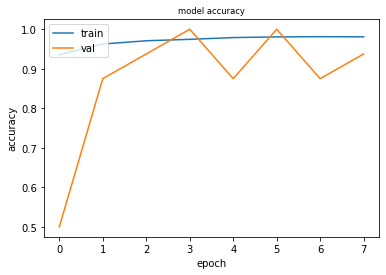

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

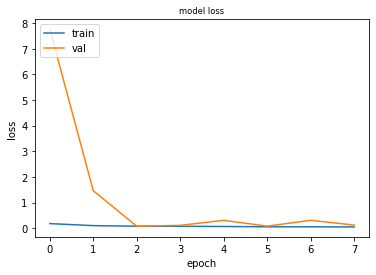

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [36]:
print("results")
y_pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)  
y_pred = y_pred.argmax(axis=-1)
y_true = test_generator.classes

numofbatch = len(test_generator)
batch_no = random.randint(0, numofbatch-1)
y_img_batch, y_true_batch = test_generator[batch_no] 
y_true_batch = y_true_batch.argmax(axis=-1)

y_pred_batch = model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis=-1)

sizeofbatch = len(y_true_batch)
print("-"*35)
print("%s%d"%     ("Selected Batch No       : ", batch_no))
print("-"*35)
print("%s%d"%     ("Batch Size              : ", len(y_pred_batch)))
print("-"*35)
print("%s%.2f%s"% ("Accuracy                : ", np.mean(y_true==y_pred)*100, "%"))
print("-"*35)

results
1/1 [==============================] - 10s 10s/step
-----------------------------------
Selected Batch No       : 0
-----------------------------------
Batch Size              : 624
-----------------------------------
Accuracy                : 92.63%
-----------------------------------


In [37]:
def select_image_by_category(image_dir, image_count_per_category):
    classes = os.listdir(image_dir)
    class_count = len(classes)
    image_file_paths = {}
    for i in range(class_count):
        subdir_path = image_dir+"/"+classes[i]
        subdir_files = os.listdir(subdir_path)

        subdir_file_count = len(subdir_files)

        subdir_file_mem = {}
        
        subdir_file_index = -1
        
        image_file_paths[classes[i]] = []
        
        for j in range(image_count_per_category):
            while subdir_file_index in subdir_file_mem:
                subdir_file_index = random.randint(0, subdir_file_count-1)
                
            subdir_file_mem[subdir_file_index] = 1
            
            subdir_file_name = subdir_files[subdir_file_index]
            subdir_file_path = subdir_path+ "/" + subdir_file_name

            image_file_paths[classes[i]].append(subdir_file_path)
            
    return image_file_paths


def get_fig_axs(subplot_params):
    fig, axs = plt.subplots(
        nrows=subplot_params["nrows"], ncols=subplot_params["ncols"], 
        figsize=(subplot_params["figsize_col"], subplot_params["figsize_row"]),
        dpi=subplot_params["dpi"], facecolor=subplot_params["facecolor"], 
        edgecolor=subplot_params["edgecolor"], subplot_kw=subplot_params["subplot_kw"])
        
    return fig, axs
    

def plot_sample_image(image_file_paths, plot_params, subplot_params, update_image=True):
    fig, axs = get_fig_axs(subplot_params)
    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])
    i=0
    for img_filepath in image_file_paths:
        img = cv2.imread(img_filepath, 1)
        plt.title(img_filepath.split("/")[-1])
        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        i=i+1
        
    if plot_params["update_image"] and os.path.exists(plot_params["image_file_name"]):
        os.remove(plot_params["image_file_name"])  
    if plot_params["save"]:
        fig.savefig(plot_params["image_file_name"], dpi=plot_params["dpi"])
        
    plt.tight_layout()
    plt.show()
    
    
def show_class_sample_images(directory, image_count_per_category=5, save=False, dpi=100, update_image=False):
    class_count = len(os.listdir(directory))
    print("Number of Class: ", class_count)
    sample_img_by_class = select_image_by_category(directory, image_count_per_category)
    for class_name in sample_img_by_class:
        plot_params = get_reset_plot_params(image_file_name="img.png", save = save, dpi=dpi, update_image=update_image)
        subplot_params = get_reset_subplot_params(nrows=1, ncols=image_count_per_category, dpi=dpi)
        print("%s%s%s"%("-"*55, name_correct(class_name), "-"*55))
        plot_sample_image(sample_img_by_class[class_name], plot_params, subplot_params)
        print("")
    print("%s%s%d%s"%("-"*55, "All Class Printed:", class_count, "-"*55))

def show_predictions(y_img_batch, y_true, y_pred, subplot_params, plot_params, class_map, testing_dir, image_file_name, count=8, sample=True):
    fig, axs = get_fig_axs(subplot_params)
    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])
    
    file_names = test_generator.filenames
    m = {}
    length = len(y_true)
    for i in range(0, count): 
        num = i
        if sample:
            num = random.randint(0, length-1)
            while num in m:
                num = int(random.randint(0, length-1))

            m[num]=1

        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        img = cv2.imread(testing_dir+"/"+ file_names[num], 1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        
        original = class_map[y_true[num]]
        predicted = class_map[y_pred[num]]
        title_text = ("%s%s%s%s%s"%("True: ", original, "\n", "Pred: ", predicted))
        if original==predicted:
            plt.title(title_text)
        else:
            plt.title(title_text, color='red')

        fig.savefig(image_file_name, dpi=subplot_params["dpi"])

    plt.tight_layout()
    plt.show()

def get_reset_subplot_params(nrows, ncols, dpi):
    subplot_params = {}
    subplot_params["nrows"] = nrows
    subplot_params["ncols"] = ncols
    subplot_params["figsize_col"] = subplot_params["ncols"]*2.5
    subplot_params["figsize_row"] = subplot_params["nrows"]*2.5
    subplot_params["dpi"] = dpi
    subplot_params["facecolor"] = 'w'
    subplot_params["edgecolor"] = 'k'
    subplot_params["subplot_kw"] = {'xticks': [], 'yticks': []}
    subplot_params["axes.titlesize"] = 'small'
    subplot_params["hspace"] = 0.5
    subplot_params["wspace"] = 0.3
    return subplot_params

def get_reset_plot_params(figsize=(15, 5), title="", xlabel ="", ylabel="", legends=[], title_fontsize = 18, label_fontsize = 14, image_file_name="", save = False, dpi=100, update_image=True):
    plot_params = {}
    plot_params["figsize"] = figsize
    plot_params["title"] = title
    plot_params["xlabel"] = xlabel
    plot_params["ylabel"] = ylabel
    plot_params["legends"] = legends 
    plot_params["title_fontsize"] = title_fontsize
    plot_params["axes.titlesize"] = "small"
    plot_params["label_fontsize"] = label_fontsize
    plot_params["image_file_name"] = image_file_name
    plot_params["save"] = save
    plot_params["update_image"] = update_image
    plot_params["subplot"] = None
    return plot_params

In [38]:
figure_directory = r'/content/output/figures'
image_file_name_batch = figure_directory+"/result"
image_file_name_sample = figure_directory+"/sample"

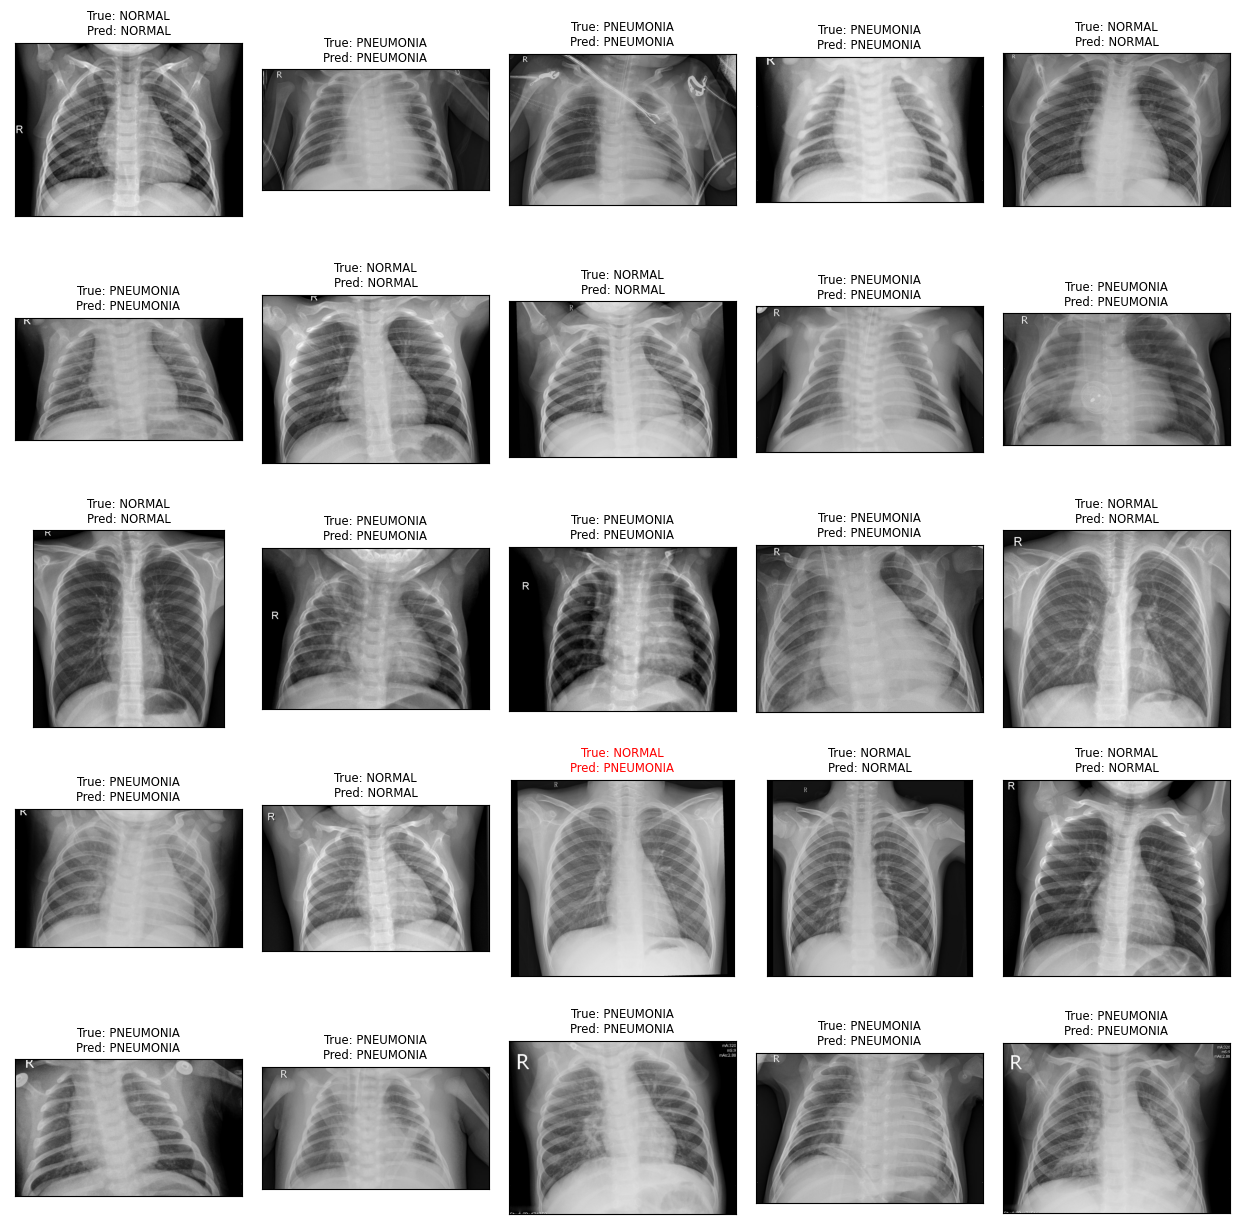

In [39]:
num_images = 25


dpi=100
ncols = 5
nrows = int(num_images/5)

count = ncols*nrows

class_map = {v: k for k, v in test_generator.class_indices.items()}
subplot_params = get_reset_subplot_params(nrows, ncols, dpi)
plot_params = get_reset_plot_params()

show_predictions(y_img_batch, y_true_batch, y_pred_batch, subplot_params, plot_params, class_map, testing_dir, image_file_name_sample, count=count, sample=True)